Отрисовка модельных изображений:

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cmath as cm
import numpy.fft as nfft
import scipy.signal as sgnl

In [2]:
def SaveLines1 (N = 512, npoints = 3, nimages = 1, wd = 10):
    for i in range(1, nimages+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        points = np.random.randint(0, N, 2*npoints)
        idraw.line(xy=tuple(points), fill='white', width=wd)
        s = 'lines_(' + str(i) + ').png'
        img.save(s)

def SaveSircles (N = 512, ns = 3):
    img = Image.new('1', (N, N), 'white')
    ns = 4*ns
    idraw = ImageDraw.Draw(img)
    for j in range(0, ns//2):
        k = 2*j*N//ns
        idraw.ellipse( (k, k, N-k, N-k), 'black', 'black')
        k = (2*j+1)*N//ns
        idraw.ellipse( ((k, k, N-k, N-k)), 'white', 'white')
    img.save('sircles.png')

In [3]:
N = 512 #разрешение изображений
n_points = 4
n_images = 12  #количество слоев

line_width = 5
n_sircles = 60

dz = 200

In [4]:
def SaveLines (N = 512, nimages = 1):
    for i in range(1, n_images+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        idraw.line((i*N/(n_images+1), 0, i*N/(n_images+1), N), fill='white', width=7)
        s = 'lines_' + str(i) + '.png'
        img.save(s)

In [5]:
def SaveSectors (N = 512, n_points = 5):
    for i in range(1, n_images+1):
        img = Image.new('1', (N, N), 'black')    
        idraw = ImageDraw.Draw(img)
        for j in range(1, n_points+1):
            idraw.pieslice(xy=(10, 10, N-10, N-10), 
                           start=360/(n_points)*(j-1) + 10*i, 
                           end=180/(n_points)*(2*j-1) + 10*i, 
                           fill='white', outline='black')
        s = 'sectors_' + str(i) + '.png'
        img.save(s)

In [29]:
SaveSectors(N = 512, n_points = 5)

In [ ]:
SaveLines(512, 12)

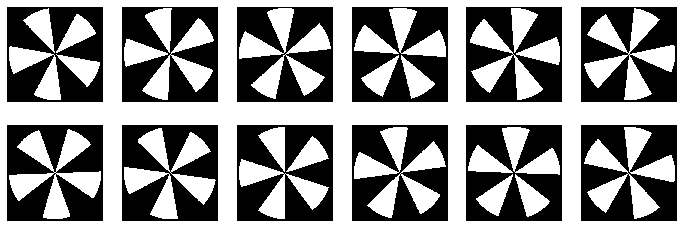

In [36]:
pic_box = plt.figure(figsize=(12,4))

for i in range (1, n_images+1):
  pic_box.add_subplot(2,6,i)
  plt.imshow(Image.open("sectors_" + str(i) + ".png"), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
  plt.axis('off')

plt.show()

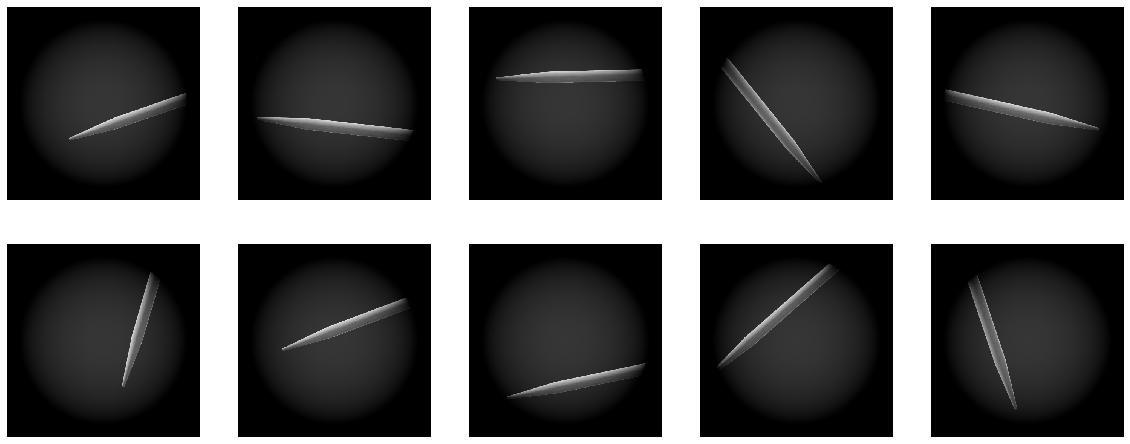

In [13]:
pic_box = plt.figure(figsize=(20,8))

for i in range (0, 10):
  pic_box.add_subplot(2,5,i+1)
  plt.imshow(Image.open("src_299" + str(i) + ".png"), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
  plt.axis('off')

plt.show()

Функция рассеяния точки:

In [6]:
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны

In [7]:
def M(x, y):                      #функция зрачка
    if (x*x + y*y) < r*r:
        return 1.0
    else:
        return 0.0

def dnm(dz):
    return dz*r/f*r/2/f

def ps(x, y, dz):
    return dnm(dz)*(x*x + y*y)/r/r*2*cm.pi/L

def p(x, y):
    return 0.5*cm.pi*(x*x + y*y)

def h(dz):
    arr = np.empty((N, N), dtype="complex")
    for i in range (0, N):
        for k in range (0, N):
            x = 2*i*cm.pi/N - cm.pi
            y = cm.pi - 2*k*cm.pi/N
            arr[i, k] = M(x, y) * cm.exp(1j*ps(x, y, dz) + 1j*p(x, y))
    arr = nfft.fft2(arr)    #дискретное двумерное преобразование Фурьe
    arr = nfft.fftshift(arr)
    g = np.empty((N, N), dtype="double")
    arr_r = np.abs(arr)
    for i in range (0, N):
        for k in range (0, N):
            g[i, k] = (arr_r[i, k])**2 #(cm.polar(arr[i, k])[0])**2
    m = np.amax(g)
    g = g/m
    return g

In [8]:
dz = 750                        #(микрон) расстояние между слоями

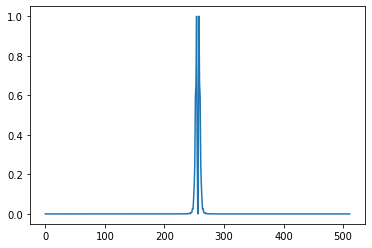

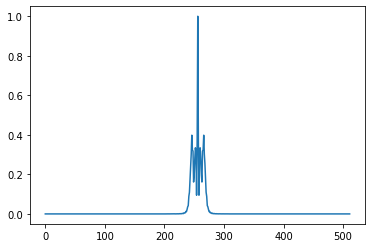

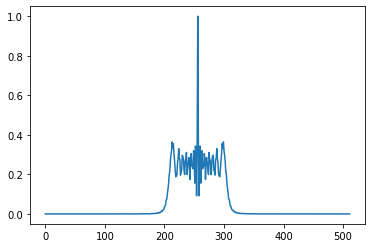

In [31]:
h1 = h(0)
h2 = h(150)
h3 = h(750)

fig0 = plt.figure()
plt.plot(h1[256])
fig0.savefig('h1_0.png', bbox_inches = 'tight')

fig150 = plt.figure()
plt.plot(h2[256])
fig150.savefig('h1_150.png', bbox_inches = 'tight')

fig750 = plt.figure()
plt.plot(h3[256])
fig750.savefig('h1_750.png', bbox_inches = 'tight')

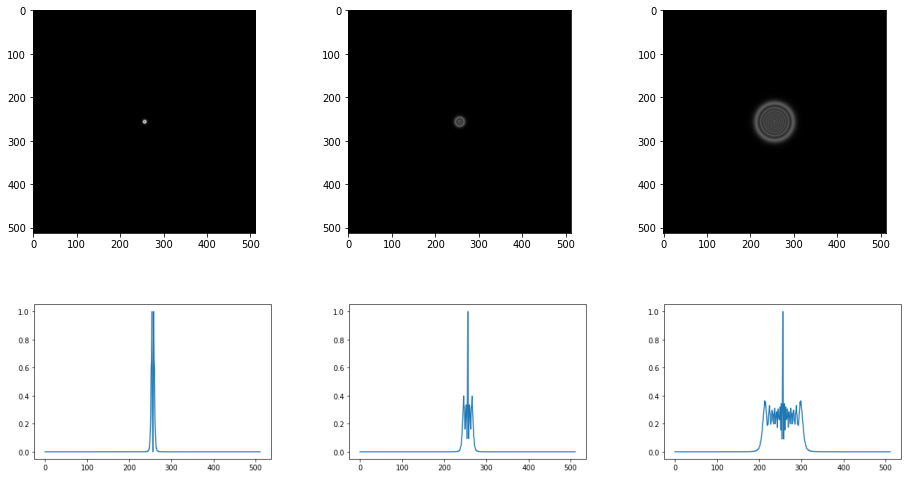

In [32]:
pic_box = plt.figure(figsize=(16,9))

pic_box.add_subplot(2,3,1)
plt.imshow(h1, cmap='gray')

pic_box.add_subplot(2,3,2)
plt.imshow(h2, cmap='gray')


pic_box.add_subplot(2,3,3)
plt.imshow(h3, cmap='gray')


pic_box.add_subplot(2,3,4)
plt.imshow(Image.open("h1_0.png"))
plt.axis('off')

pic_box.add_subplot(2,3,5)
plt.imshow(Image.open("h1_150.png"))
plt.axis('off')

pic_box.add_subplot(2,3,6)
plt.imshow(Image.open("h1_750.png"))
plt.axis('off')

plt.show()

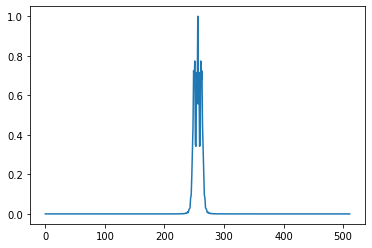

In [ ]:
plt.plot(h1[256])
plt.show()

Свертка напрямую:

In [ ]:
def conv(image_number, dz):
    im = Image.open("lines_" + str(image_number) + ".png")
    res = sgnl.convolve2d(np.asarray(im), h(dz), mode='full', boundary='fill', fillvalue=0)
    return res

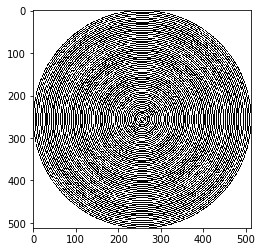

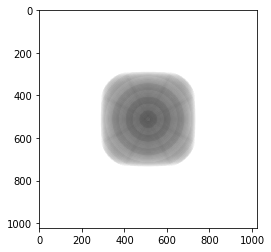

In [ ]:
dz = 75
im_s = Image.open("sircles.png")
res_s = sgnl.convolve2d(np.asarray(im_s), h(dz), mode='full', boundary='fill', fillvalue=255)

plt.imshow(im_s, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(res_s, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

Теорема о свертке и преобразования Фурье:

In [20]:
def conv_F(image_number, dz):
    im = Image.open("src_299" + str(image_number - 1) + ".png")
    im = im.convert('L')
    im_F = nfft.fftshift(nfft.fft2(np.asarray(im)))
    im_F = im_F/np.max(np.abs(im_F))
    h_F = nfft.fftshift(nfft.fft2(h(dz)))
    h_F = h_F/np.max(np.abs(h_F))
    res_F = im_F*h_F
    res = np.abs(nfft.ifftshift(nfft.ifft2(res_F)))
    #m = np.amax(res)
    #res = res/m
    return res

Свертки одного слоя с функциями рассеяния для различных dz:

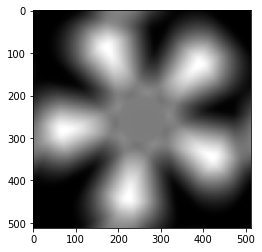

In [ ]:
res = conv_F(1, 11*75)
#вклад 12-того слоя при фокусировке на слое 1
plt.imshow(res, interpolation='nearest', cmap='gray')
#plt.colorbar()
plt.show()

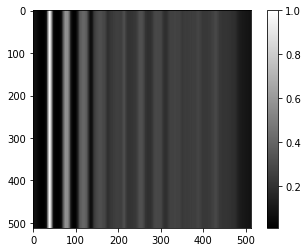

In [ ]:
plt.imshow(layer_F(1), interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

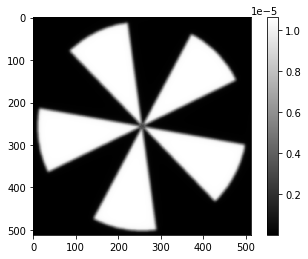

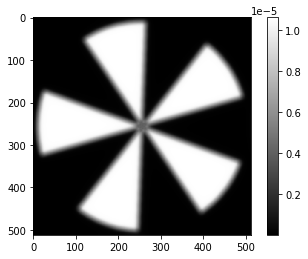

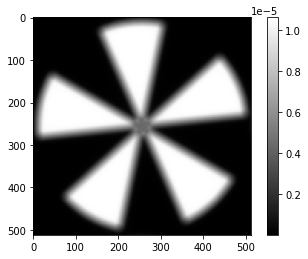

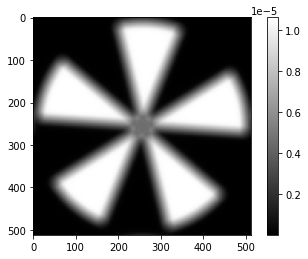

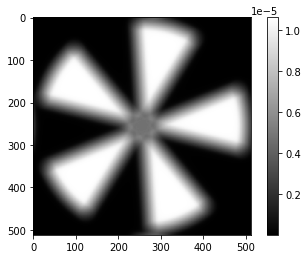

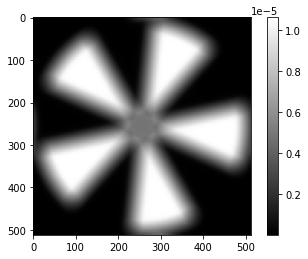

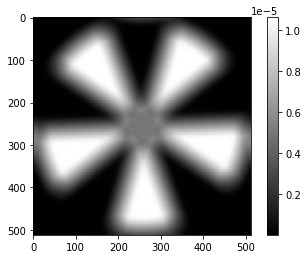

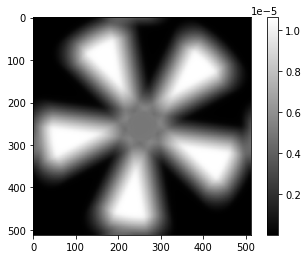

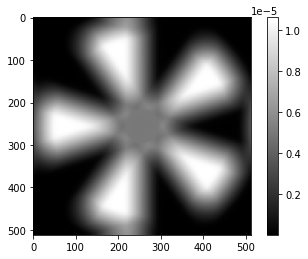

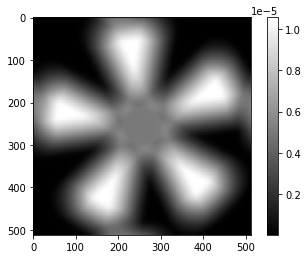

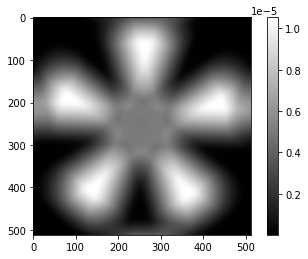

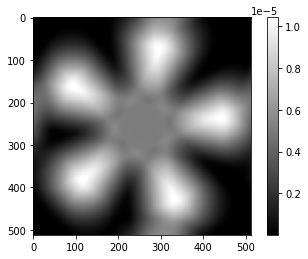

In [ ]:
dz = 75
for i in range (1, n_images+1):
    res = conv_F(i, np.abs(dz*(i - 1)))        
    #вклад i-того слоя при фокусировке на слое 1
    plt.imshow(res, interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
res = conv(1, dz*5)        
#вклад 1-го слоя при фокусировке на слое 1
plt.imshow(res, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

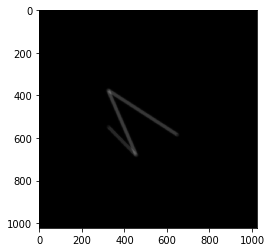

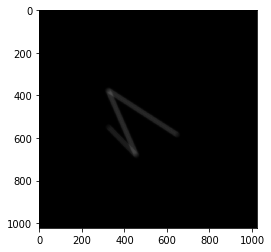

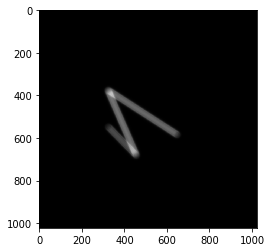

In [ ]:
for i in range (1, n_images+1):
    res = conv(n_images, dz*i)
    plt.imshow(res, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    plt.show()

Построение наблюдаемых изображений:

In [ ]:
def layer(i):
    res = conv(i, 0)
    for k in range(1, n_images+1):
        if k != i:
            res = res + conv(k, k-i)*dz
    return res

plt.figure(figsize=(10, 10))
plt.imshow(layer(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
def layer(i):
    res = conv(i, 0)
    for k in range(1, n_images+1):
        if k != i:
            res = res + conv(k, k-i)/abs(k-i)
    return res

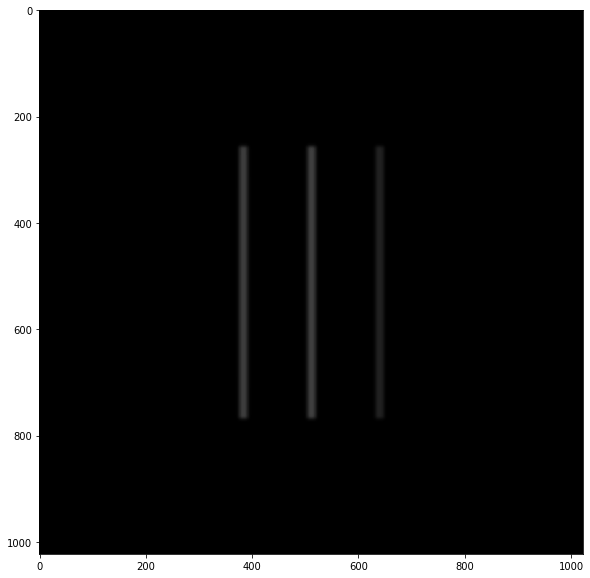

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(layer(1), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

In [16]:
def layer_F(i):
    res = conv_F(1, (1-i)*dz)*dz
    for k in range(2, 11):
        res = res + conv_F(k, (k-i)*dz)*dz
    return res/np.max(res)

In [11]:
dz = 150


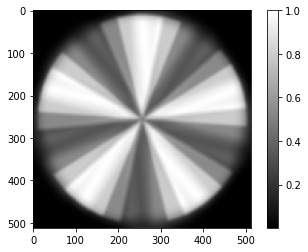

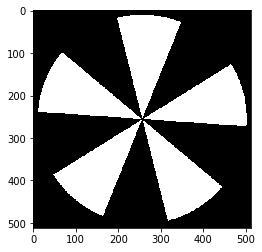

In [ ]:
#res = conv_F(1, -3*dz)*dz
res = conv_F(2, -2*dz)*dz
res = res + conv_F(3, -1*dz)*dz
res = res + conv_F(4, 0)*dz
res = res + conv_F(5, 1*dz)*dz
res = res + conv_F(6, 2*dz)*dz
#res = res + conv_F(7, 3*dz)*dz
res = res/np.max(res)

plt.imshow(res, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(Image.open("sectors_4.png"), interpolation='nearest', cmap='gray', vmin=0, vmax=255)
plt.show()

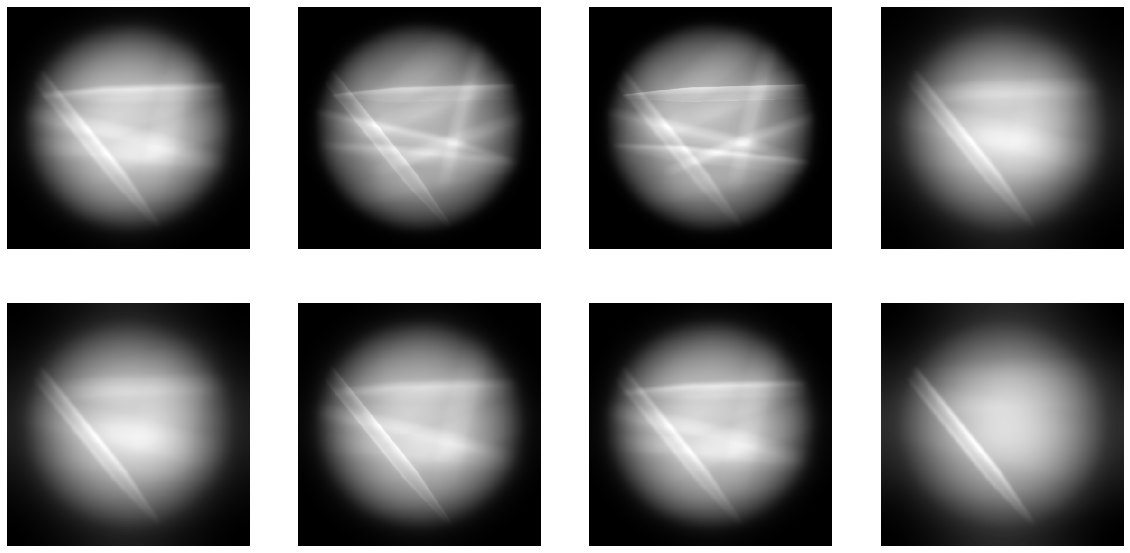

In [23]:
pic_box = plt.figure(figsize=(20,10))

pic_box.add_subplot(2,4,1)
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 225                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,2)
r = 1.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 225                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,3)
r = 2.0                           #(мм) радиус зрачка
f = 30                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 225                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,4)
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.25                           #(микрон) длина волны
dz = 225                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,5)
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 500                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,6)
r = 1.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 500                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,7)
r = 2.0                           #(мм) радиус зрачка
f = 30                            #(мм) фокусное расстояние
L = 0.5                           #(микрон) длина волны
dz = 500                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')

pic_box.add_subplot(2,4,8)
r = 2.0                           #(мм) радиус зрачка
f = 20                            #(мм) фокусное расстояние
L = 0.25                           #(микрон) длина волны
dz = 500                          #(микрон) между слоями
plt.imshow(layer_F(4), interpolation='nearest', cmap='gray')
plt.axis('off')


plt.show()

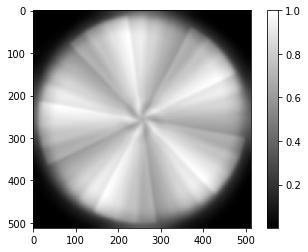

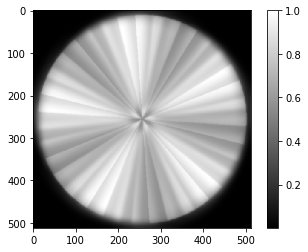

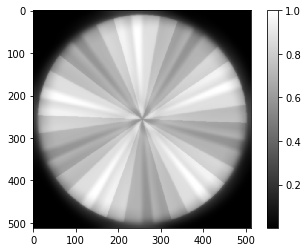

In [ ]:
plt.imshow(layer_F(1), interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(layer_F(6), interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(layer_F(12), interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

Функция для векторного частотного критерия A(r, o):

In [25]:
img = np.asarray(Image.open("src_2994.png"))         #определить изображение для функции

In [26]:
def undersum_func(img):
  o = img/np.var(img)
  o = o/np.mean(o)
  o_f = np.abs(nfft.fftshift(nfft.fft2(o)))
  #o_f = np.abs(nfft.fft2(o))
  return o_f

def A(r):
  m = 0
  sum = 0
  for i in range (0, N):
    for j in range (0, N):
      rij = (i*i + j*j)
      if (r*r <= rij) and (rij <= (r+1)*(r+1)):
        m = m+1
        sum = sum + o_f[i][j]
  return sum/m

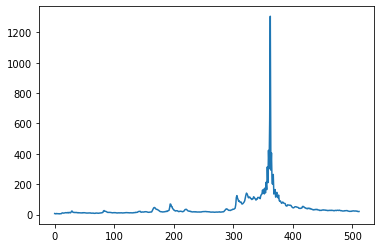

In [28]:
img_f = Image.open("src_2994.png")
img = np.asarray(img_f.convert('L'))

img = img/np.max(img)
o_f = undersum_func(img)

x = np.linspace(0, 511, 512)
y = [A(i) for i in x]
plt.plot(y)
plt.show()

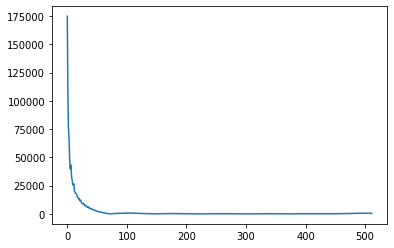

In [ ]:
img = np.asarray(Image.open("lines_3.png"))
o_f = undersum_func(img)

y = [A(i) for i in x]
plt.plot(y)
plt.show()

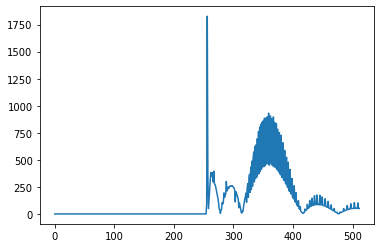

In [ ]:
img = np.asarray(Image.open("lines_12.png"))
o_f = undersum_func(img)

y = [A(i) for i in x]
plt.plot(y)
plt.show()

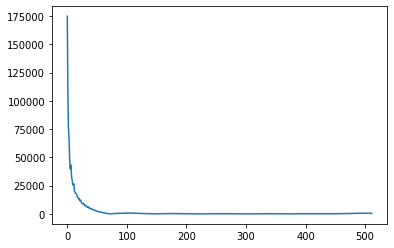

In [ ]:
img = np.asarray(Image.open("lines_12.png"))
o_f = undersum_func(img)

y = [A(i) for i in x]
plt.plot(y)
plt.show()

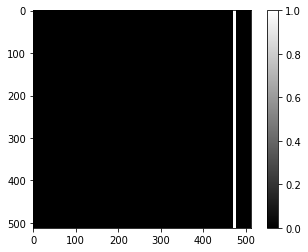

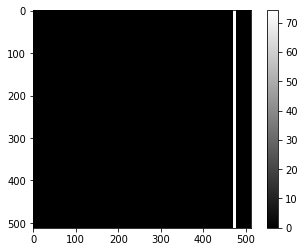

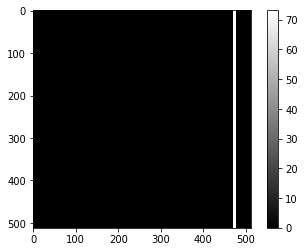

In [ ]:
img = np.asarray(Image.open("lines_12.png"))
plt.imshow(img, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

img = img/np.var(img)

plt.imshow(img, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

img = img/np.mean(img)

plt.imshow(img, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.show()

